# 4X Study Dashboard
This notebook is used to analyze data from the 4X study conducted in March 2018.

# Imports and Global Setup

In [1]:
# data processing
import math
import json
from multiprocessing import Pool, cpu_count
from multiprocessing.dummy import Pool as ThreadPool 
from functools import reduce
from collections import Counter

import requests
import pandas as pd
import numpy as np
from scipy import stats

from datetime import datetime, timezone
from copy import deepcopy
from tqdm import *

In [2]:
# google
import gspread
from oauth2client.service_account import ServiceAccountCredentials
from operator import itemgetter

In [3]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

In [4]:
# palette
sns.set(font_scale=1.5, style='whitegrid')
# sns.set_palette("cubehelix")
sns.set_palette(sns.cubehelix_palette(rot=-.4))

## Setup Google Sheets Auth

In [5]:
# setup connection
scope = ['https://spreadsheets.google.com/feeds']
credentials = ServiceAccountCredentials.from_json_keyfile_name('credential.json', scope)
gc = gspread.authorize(credentials)

# Load in data

## Log Data from LES

In [132]:
# URLs for different conditions
url_4x = 'https://les-4x.herokuapp.com/parse/classes/'
url_opp_location = 'https://les-opplocation.herokuapp.com/parse/classes/'
url_opp_distance = 'https://les-oppdistance.herokuapp.com/parse/classes/'

# shared header and data
header = {'X-Parse-Application-Id': 'PkngqKtJygU9WiQ1GXM9eC0a17tKmioKKmpWftYr'}
data = {'limit': '10000'}

# study start and end
start_time = '2018-03-05 06:00:00'
mid_time = '2018-03-12 05:00:00'
end_time = '2018-03-20 05:00:00'

start_time_date = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')
mid_time_date = datetime.strptime(mid_time, '%Y-%m-%d %H:%M:%S')
end_time_date = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S')

print('Study Length: {}'.format(end_time_date - start_time_date))

Study Length: 14 days, 23:00:00


In [7]:
def load_data(base_url, header, data, start_time, end_time):
    """
    Loads in all needed tables from database, given url.
    
    Input: 
        base_url (string): url to pull data from
        header (dict): application id and other auth
        data (dict): data to pass into query
        start_time (datetime): start time for data
        end_time (datetime): end time for data 
    
    Return:
        (dict): dict where keys are collection names and values are Pandas objects containing data
    """
    # declare collection list
    collection_list = ['_User', 'ServerLog', 'DebugLog', 'ForYouViewLog', 'ApplicationHeartbeat',
                       'TaskLocations', 'LocationTypeMetadata', 'beacons', 'EnRouteLocations',
                       'AtLocationNotificationsSent', 'AtLocationNotificationResponses',
                       'EnRouteNotificationsSent', 'EnRouteNotificationResponses',
                       'AtDistanceNotificationsSent', 'AtDistanceNotificationResponses']
    
    # loop through and load data for each collection
    output = {}
    for collection in collection_list:
        current_response = requests.get(base_url + collection, headers=header, data=data)

        current_data = pd.DataFrame(current_response.json()['results'])
        if len(current_data) != 0 and collection not in ['LocationTypeMetadata', 'EnRouteLocations']:
            current_data['createdAt'] = pd.to_datetime(current_data['createdAt'])
            current_data['updatedAt'] = pd.to_datetime(current_data['updatedAt'])
            
            if collection != '_User':
                current_data = current_data[(current_data['createdAt'] >= start_time) & (current_data['createdAt'] < end_time)]

        output[collection] = current_data
    
    return output

def load_data_parallel(url):
    return load_data(url, header, data, start_time, end_time)

In [8]:
# fetch log data
urls = [url_4x, url_opp_location, url_opp_distance]
pool = ThreadPool(cpu_count())
results = pool.map(load_data_parallel, urls)
pool.close()
pool.join()

data_4x = results[0]
data_opp_loc = results[1]
data_opp_dist = results[2]

## Post-Study Survey Data

In [9]:
def load_post_study_data(url, new_col_names=[]):
    """
    Loads in and returns post-study as a Pandas DataFrame with header remapped according to values above.
    
    Inputs:
        url (string): url of spreadsheet to load in
        new_col_names (list): list of strings for new column names
    
    Returns:
        (DataFrame): Pandas DataFrame with header remapped above
    """
    url_connection = gc.open_by_url(url)
    raw_data = url_connection.get_worksheet(0).get_all_values()
    
    output_df = pd.DataFrame(raw_data[1:], columns=raw_data[0])
    if len(new_col_names) > 0:
        output_df.columns = new_col_names

    return output_df

In [10]:
# setup 4X post-survey data
url_4x = 'https://docs.google.com/spreadsheets/d/1rCH32DdAfnOSoe-qNIQgO7rQei2VATHxLlGfP0bCNg8/edit#gid=339656711'
cols_4x = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altprefs',
    'expand_info_disruption',
    'expand_info_number_notif',
    'exploit_atloc',
    'exploit_enroute',
    'exploit_disruption',
    'miscellaneous'
]
post_study_4x = load_post_study_data(url_4x, new_col_names=cols_4x)
post_study_4x.to_csv('./analysis/post_study_4x.csv', index=False)
post_study_4x.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,expand_info_going,expand_info_going_notgo,expand_info_notuseful,expand_info_altprefs,expand_info_disruption,expand_info_number_notif,exploit_atloc,exploit_enroute,exploit_disruption,miscellaneous
0,3/18/2018 23:17:30,allisonsun2018@u.northwestern.edu,Allison Sun,3: Neutral,"2: Rarely, in less than 10% of the notifications",4: Somewhat likely,I liked being notified for free food in Ford a...,Always responded to the notifications for Ford...,Can't think of any instances when I didn't res...,2: Rarely disruptive,Only went the free food places in ford because...,N/A,N/A,Coffee shops that I frequent more like Peets a...,2: Rarely disruptive,2: Fewer than I would have liked,N/A,N/A,0: N/A,


In [11]:
# setup 4X post-survey data
url_opp_loc = 'https://docs.google.com/spreadsheets/d/15x6yST-eJh1azQJxQRtkOb37E397RJhzG-3CDbPCflk/edit#gid=1062479755'
cols_opp_loc = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'miscellaneous'
]
post_study_opp_loc = load_post_study_data(url_opp_loc, new_col_names=cols_opp_loc)
post_study_opp_loc.to_csv('./analysis/post_study_opp_loc.csv', index=False)
post_study_opp_loc.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,miscellaneous
0,3/19/2018 18:45:44,abigailpetrotta2021@u.northwestern.edu,Abigail Petrotta,4: Valuable,"2: Rarely, in less than 10% of the notifications",4: Somewhat likely,"Super easy to use, did not like how there was ...",I wanted to help this study,I did not see the notification until later,"1: Not disruptive, easy to do and continue on ...",


In [12]:
# setup 4X post-survey data
url_opp_dist = 'https://docs.google.com/spreadsheets/d/1YJVo7ouNklEXb1DLZlzGttoaTDk-z2WJxVPIRmB5hyw/edit#gid=446248525'
cols_opp_dist = [
    'timestamp',
    'email_address',
    'name',
    'overall_value',
    'overall_disruption',
    'future_use',
    'overall_experience',
    'explore_respond',
    'explore_not_respond',
    'explore_disruption',
    'expand_noinfo',
    'expand_noinfo_disruption',
    'expand_noinfo_number_notif',
    'expand_info_going',
    'expand_info_going_notgo',
    'expand_info_notuseful',
    'expand_info_altpref',
    'expand_info_disruption',
    'expand_info_number_notif',
    'miscellaneous'
]
post_study_opp_dist = load_post_study_data(url_opp_dist, new_col_names=cols_opp_dist)
post_study_opp_dist.to_csv('./analysis/post_study_opp_dist.csv', index=False)
post_study_opp_dist.head(1)

,timestamp,email_address,name,overall_value,overall_disruption,future_use,overall_experience,explore_respond,explore_not_respond,explore_disruption,expand_noinfo,expand_noinfo_disruption,expand_noinfo_number_notif,expand_info_going,expand_info_going_notgo,expand_info_notuseful,expand_info_altpref,expand_info_disruption,expand_info_number_notif,miscellaneous
0,3/19/2018 9:16:56,allyodo13@gmail.com,Ally O'Donnell,2: Invaluable,"3: Occasionally, in about 30% of the notificat...",1: Not likely,The most frustrating thing was when the app wo...,It wasn't an inconvenience for me to respond. ...,I was in a rush to class or I didn't see the n...,3: Occasionally disruptive,I just didn't want to go. I never went to look...,"5: A great deal disruptive, I had to stop what...",5: Far more than I would have liked,I already had a routine in mind. I never went ...,No,"I never got notifications for free pizza, whic...","Places specifically in tech, lesser known loca...",3: Occasionally disruptive,4: More than I would have liked,


# Data Setup
This section of the notebook is used to monitor the data coming in from the study. Some measures we see here may be used within the paper

## Common Functions and Data

In [13]:
def get_merged_at_location(tasklocations, atlocnotif, atlocresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtLocation case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atlocnotif (DataFrame): DataFrame of AtLocationNotificationsSent
        atlocresp (DataFrame): DataFrame of AtLocationNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtLocationNotifications without duplicates
    atlocnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtLocationNotificationResponses without duplicates
    atlocresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atlocresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtLocation notifications and responses, with some data from TaskLocations
    atloc = atlocnotif.merge(tasklocations[['objectId', 'locationType', 'locationName', 'beaconId']],
                             how='inner', left_on='taskLocationId', right_on='objectId')
    atloc = atloc.merge(atlocresp[['question', 'response', 'timestamp', 'taskLocationId', 'vendorId']],
                        how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atloc['objectId']
    atloc.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'},
                 inplace=True)
    
    # fill blank columns
    atloc[['question', 'response']] = atloc[['question', 'response']].fillna(value='Missed Notification')
    atloc[['distanceToLocation', 'responseTimestamp']] = atloc[['distanceToLocation', 'responseTimestamp']].fillna(value=-1)

    # type columns
    atloc_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atloc[atloc_int_cols] = atloc[atloc_int_cols].apply(lambda x: x.astype(np.int64))
    
    # add remappedResponses column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    atloc['remappedResponses'] = atloc['response']
    atloc.loc[~atloc['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    atloc.loc[atloc['remappedResponses'] == 'com.apple.UNNotificationDismissActionIdentifier', 'remappedResponses'] = 'Dismissed Notification'
    atloc.loc[atloc['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'
    
    # reorder columns
    atloc_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation',
                          'locationType', 'locationName','gmtOffset', 'notificationTimestamp', 'notificationString',
                          'question', 'response', 'remappedResponses', 'responseTimestamp']
    atloc = atloc[atloc_col_ordering]
    
    return atloc

In [14]:
def get_merged_at_distance(tasklocations, atdistnotif, atdistresp):
    """
    Sets up a Pandas DataFrame with (1) TaskLocation, (2) NotificationSent, and (3) NotificationResponse data
    merged together for AtDistance case.
    
    Input:
        tasklocations (DataFrame): DataFrame of TaskLocations
        atdistnotif (DataFrame): DataFrame of AtDistanceNotificationsSent
        atdistresp (DataFrame): DataFrame of AtDistanceNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get AtDistanceNotifications without duplicates
    atdistnotif.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistnotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    atdistresp.drop_duplicates(subset=['taskLocationId', 'vendorId'], keep='last', inplace=True)
    atdistresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine AtDistance notifications and responses, with some data from TaskLocations
    atdist = atdistnotif.merge(tasklocations[['objectId', 'beaconId', 'locationName']],
                               how='inner', left_on='taskLocationId', right_on='objectId')
    atdist = atdist.merge(atdistresp[['emaResponse', 'timestamp', 'taskLocationId', 'vendorId']],
                          how='left', on=['taskLocationId', 'vendorId'])
    
    # clean columns
    del atdist['objectId']
    atdist.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    atdist_col_ordering = ['taskLocationId', 'vendorId', 'beaconId', 'distanceToLocation', 'bearingToLocation',
                           'locationType', 'locationName', 'notificationDistance', 'sentBy', 'infoIncluded',
                           'gmtOffset', 'notificationTimestamp', 'emaResponse', 'responseTimestamp']
    atdist = atdist[atdist_col_ordering]
    
    # fill blank columns
    atdist['emaResponse'] = atdist['emaResponse'].fillna(value='Missed Notification')
    atdist['responseTimestamp'] = atdist['responseTimestamp'].fillna(value=-1)
    
    # remap columns
    atdist.loc[atdist['emaResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'emaResponse'] = 'Dismissed Notification'

    # type columns
    atdist_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    atdist[atdist_int_cols] = atdist[atdist_int_cols].apply(lambda x: x.astype(np.int64))
    
    return atdist

In [15]:
def get_merged_en_route(enroutelocations, enroutenotif, enrouteresp):
    """
    Sets up a Pandas DataFrame with (1) EnRouteLocations, (2) NotificationSent, and (3) NotificationResponse data
    merged together for EnRoute case.
    
    Input:
        enroutelocations (DataFrame): DataFrame of EnRouteLocations
        enroutenotif (DataFrame): DataFrame of EnRouteNotificationsSent
        enrouteresp (DataFrame): DataFrame of EnRouteNotificationResponses
    
    Return:
        (DataFrame): merged DataFrame of inputs
    """
    # get EnRouteNotifications without duplicates
    enroutenotif.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enroutenotif.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)

    # get AtDistanceNotificationResponses without duplicates
    enrouteresp.drop_duplicates(subset=['enRouteLocationId', 'vendorId'], keep='last', inplace=True)
    enrouteresp.drop(['objectId', 'createdAt', 'updatedAt'], axis=1, inplace=True)
    
    # combine EnRouteNotifications and responses, with some data from EnRouteLocations
    enroute = enroutenotif.merge(enroutelocations[['objectId', 'locationName', 'locationType']],
                               how='inner', left_on='enRouteLocationId', right_on='objectId')
    enroute = enroute.merge(enrouteresp[['questionResponse', 'timestamp', 'enRouteLocationId', 'vendorId']],
                            how='left', on=['enRouteLocationId', 'vendorId'])
    
    # clean columns
    del enroute['objectId']
    enroute.rename(columns={'timestamp_x': 'notificationTimestamp', 'timestamp_y': 'responseTimestamp'}, inplace=True)

    enroute_col_ordering = ['enRouteLocationId', 'vendorId', 'distanceToLocation', 'locationType', 'locationName',
                           'gmtOffset', 'notificationTimestamp', 'questionResponse', 'responseTimestamp']
    enroute = enroute[enroute_col_ordering]
    
    # fill blank columns
    enroute['questionResponse'] = enroute['questionResponse'].fillna(value='Missed Notification')
    enroute.loc[enroute['questionResponse'] == 'com.apple.UNNotificationDismissActionIdentifier', 'questionResponse'] = 'Dismissed Notification'
    
    enroute['responseTimestamp'] = enroute['responseTimestamp'].fillna(value=-1)
    
     # add validResponse column 
    invalid_responses = ['I don\'t know', 'com.apple.UNNotificationDismissActionIdentifier', 'Missed Notification']
    enroute['remappedResponses'] = enroute['questionResponse']
    enroute.loc[~enroute['remappedResponses'].isin(invalid_responses), 'remappedResponses'] = 'Valid Response'
    enroute.loc[enroute['remappedResponses'] == 'I don\'t know', 'remappedResponses'] = '"I don\'t know" Response'

    # type columns
    enroute_int_cols = ['gmtOffset','notificationTimestamp', 'responseTimestamp']
    enroute[enroute_int_cols] = enroute[enroute_int_cols].apply(lambda x: x.astype(np.int64))
    
    return enroute

In [16]:
def get_dead_apps(serverlog):
    """
    Returns a list of lists for dead apps that server has notified.
    
    Input: 
        server (DataFrame): DataFrame of ServerLog
    
    Return:
        (list of lists of strings): all dead applications notified via push
    """
    notify_log_strings = serverlog[serverlog['logString'].str.contains('Notified dead')]['logString']
    deadapp_notif_list = list(notify_log_strings.apply(lambda x: x[x.find('[') + 1:-1].split(', ')))
    return deadapp_notif_list

In [17]:
location_scaffolds = {}
for index, row in data_4x['LocationTypeMetadata'].iterrows():
    location_scaffolds[row['locationType']] = row['scaffold']

## 4X Log Data Setup

In [18]:
users_4x = deepcopy(data_4x['_User'])
users_4x = users_4x[users_4x['vendorId'] != '']

In [19]:
tasklocations_4x = deepcopy(data_4x['TaskLocations'])
enroutelocations_4x = deepcopy(data_4x['EnRouteLocations'])

atlocnotif_4x = deepcopy(data_4x['AtLocationNotificationsSent'])
atlocresp_4x = deepcopy(data_4x['AtLocationNotificationResponses'])

atdistnotif_4x = deepcopy(data_4x['AtDistanceNotificationsSent'])
atdistresp_4x = deepcopy(data_4x['AtDistanceNotificationResponses'])

enroutenotif_4x = deepcopy(data_4x['EnRouteNotificationsSent'])
enrouteresp_4x = deepcopy(data_4x['EnRouteNotificationResponses'])

print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif_4x), len(atlocresp_4x)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif_4x), len(atdistresp_4x)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif_4x), len(enrouteresp_4x)))

4X | At location notifications: 735, At location responses: 333
4X | At distance notifications: 206, At distance responses: 126
4X | En route notifications: 15, En route responses: 1


In [20]:
# remove bad users
bad_users_4x = ['0E322CAE-1091-4C9D-835F-24C36AA2A4D7']

atlocnotif_4x = atlocnotif_4x[~atlocnotif_4x['vendorId'].isin(bad_users_4x)]
atlocresp_4x = atlocresp_4x[~atlocresp_4x['vendorId'].isin(bad_users_4x)]

atdistnotif_4x = atdistnotif_4x[~atdistnotif_4x['vendorId'].isin(bad_users_4x)]
atdistresp_4x = atdistresp_4x[~atdistresp_4x['vendorId'].isin(bad_users_4x)]

enroutenotif_4x = enroutenotif_4x[~enroutenotif_4x['vendorId'].isin(bad_users_4x)]
enrouteresp_4x = enrouteresp_4x[~enrouteresp_4x['vendorId'].isin(bad_users_4x)]

print('4X | At location notifications: {}, At location responses: {}'.format(len(atlocnotif_4x), len(atlocresp_4x)))
print('4X | At distance notifications: {}, At distance responses: {}'.format(len(atdistnotif_4x), len(atdistresp_4x)))
print('4X | En route notifications: {}, En route responses: {}'.format(len(enroutenotif_4x), len(enrouteresp_4x)))

4X | At location notifications: 673, At location responses: 300
4X | At distance notifications: 201, At distance responses: 123
4X | En route notifications: 15, En route responses: 1


In [134]:
# merged data frame with all AtLocation data
atloc_4x = get_merged_at_location(deepcopy(tasklocations_4x),
                                  deepcopy(atlocnotif_4x),
                                  deepcopy(atlocresp_4x))

# add date and week
atloc_4x['date'] = pd.to_datetime(atloc_4x['notificationTimestamp'] + atloc_4x['gmtOffset'], unit='s').dt.date
atloc_4x['week'] = atloc_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [137]:
# merged data frame with all AtDistance data
atdist_4x = get_merged_at_distance(deepcopy(tasklocations_4x),
                                   deepcopy(atdistnotif_4x),
                                   deepcopy(atdistresp_4x))
atdist_4x = atdist_4x[atdist_4x['infoIncluded']] # 4X Only: remove cases without info

# add date and week
atdist_4x['date'] = pd.to_datetime(atdist_4x['notificationTimestamp'] + atdist_4x['gmtOffset'], unit='s').dt.date
atdist_4x['week'] = atdist_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [23]:
# TODO: check if all 4X people actually did give more data
atdist_4x_positive = atdist_4x[atdist_4x['emaResponse'].isin(["Yes! This info is useful, I'm going now.", "Yes. This info is useful but I'm already going there."])]
atdist_4x_positive.merge(atloc_4x, how='left', on=['vendorId', 'taskLocationId'])

,taskLocationId,vendorId,beaconId_x,distanceToLocation_x,bearingToLocation,locationType_x,locationName_x,notificationDistance,sentBy,infoIncluded,...,locationType_y,locationName_y,gmtOffset_y,notificationTimestamp_y,notificationString,question,response,remappedResponses,responseTimestamp_y,date_y
0,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,freefood,Ford Second Floor (outside McCormick Career De...,-21600.0,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520283e+09,2018-03-05
1,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,...,freefood,Ford Second Floor (outside McCormick Career De...,-21600.0,1.520283e+09,"Notified for nERqAcXEd5 (42.057016, -87.676649...",stillleft,no,Valid Response,1.520283e+09,2018-03-05
2,vKrOItaLeS,F869C396-591A-4F19-895B-5E5871924B45,,301.857400,344.121791,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,freefood,Ford Ground Floor (by the staircase),-21600.0,1.520456e+09,"Notified for vKrOItaLeS (42.057016, -87.676649...",stillleft,I don't know,"""I don't know"" Response",1.520457e+09,2018-03-07
3,vKrOItaLeS,F57CB6D4-09B3-4796-AE91-2F31BADEE832,,219.747081,316.048657,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ZBmWUZNqau,D3D3D1E2-1F39-4AB8-917D-52876AA63830,ekGHD1UW0G,300.553510,1.191497,coffeeshop,Starbucks (in Norris),300,geofence trip,True,...,coffeeshop,Starbucks (in Norris),-21600.0,1.520545e+09,Notified for beacon region ekGHD1UW0G,sharedseatingoutlets,no,Valid Response,1.520545e+09,2018-03-08
5,SfFmjmE7wD,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,cE9k7N4F4I,269.546308,38.521418,gym,Blomquist,300,geofence trip,True,...,gym,Blomquist,-18000.0,1.521506e+09,Notified for beacon region cE9k7N4F4I,Missed Notification,Missed Notification,Missed Notification,-1.000000e+00,2018-03-19


In [24]:
atdist_4x_positive

,taskLocationId,vendorId,beaconId,distanceToLocation,bearingToLocation,locationType,locationName,notificationDistance,sentBy,infoIncluded,gmtOffset,notificationTimestamp,emaResponse,responseTimestamp,date
43,nERqAcXEd5,F869C396-591A-4F19-895B-5E5871924B45,,298.826807,314.610937,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282261,"Yes! This info is useful, I'm going now.",1520282274,2018-03-05
44,nERqAcXEd5,3950424A-7986-4771-B867-E4A5624D00ED,,316.224290,138.828694,freefood,Ford Second Floor (outside McCormick Career De...,300,geofence trip,True,-21600,1520282453,"Yes! This info is useful, I'm going now.",1520282580,2018-03-05
70,vKrOItaLeS,F869C396-591A-4F19-895B-5E5871924B45,,301.857400,344.121791,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520456142,"Yes! This info is useful, I'm going now.",1520456181,2018-03-07
71,vKrOItaLeS,F57CB6D4-09B3-4796-AE91-2F31BADEE832,,219.747081,316.048657,freefood,Ford Ground Floor (by the staircase),300,geofence trip,True,-21600,1520456593,Yes. This info is useful but I'm already going...,1520456621,2018-03-07
84,ZBmWUZNqau,D3D3D1E2-1F39-4AB8-917D-52876AA63830,ekGHD1UW0G,300.553510,1.191497,coffeeshop,Starbucks (in Norris),300,geofence trip,True,-21600,1520544544,Yes. This info is useful but I'm already going...,1520544627,2018-03-08
184,SfFmjmE7wD,B2CE1B90-BD84-4B33-AE61-435FCBC195BA,cE9k7N4F4I,269.546308,38.521418,gym,Blomquist,300,geofence trip,True,-18000,1521496422,"Yes! This info is useful, I'm going now.",1521504632,2018-03-19


In [140]:
# merged data from with all EnRoute data
enroute_4x = get_merged_en_route(deepcopy(enroutelocations_4x),
                                 deepcopy(enroutenotif_4x),
                                 deepcopy(enrouteresp_4x))
enroute_4x['date'] = pd.to_datetime(enroute_4x['notificationTimestamp'] + enroute_4x['gmtOffset'], unit='s').dt.date
enroute_4x['week'] = enroute_4x['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

## Opp at Distance Log Data Setup

In [26]:
users_opp_dist = deepcopy(data_opp_dist['_User'])
users_opp_dist = users_opp_dist[users_opp_dist['vendorId'] != '']

In [27]:
tasklocations_opp_dist = deepcopy(data_opp_dist['TaskLocations'])

atlocnotif_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationsSent'])
atlocresp_opp_dist = deepcopy(data_opp_dist['AtLocationNotificationResponses'])

atdistnotif_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationsSent'])
atdistresp_opp_dist = deepcopy(data_opp_dist['AtDistanceNotificationResponses'])

In [139]:
# merged data frame with all AtLocation data
atloc_opp_dist = get_merged_at_location(deepcopy(tasklocations_opp_dist),
                                        deepcopy(atlocnotif_opp_dist),
                                        deepcopy(atlocresp_opp_dist))
atloc_opp_dist['date'] = pd.to_datetime(atloc_opp_dist['notificationTimestamp'] + atloc_opp_dist['gmtOffset'], unit='s').dt.date
atloc_opp_dist['week'] = atloc_opp_dist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

In [138]:
# merged data frame with all AtDistance data
atdist_opp_dist = get_merged_at_distance(deepcopy(tasklocations_opp_dist),
                                         deepcopy(atdistnotif_opp_dist),
                                         deepcopy(atdistresp_opp_dist))
atdist_opp_dist['date'] = pd.to_datetime(atdist_opp_dist['notificationTimestamp'] + atdist_opp_dist['gmtOffset'], unit='s').dt.date
atdist_opp_dist['week'] = atdist_opp_dist['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

## Opp at Location Log Data Setup

In [30]:
users_opp_loc = deepcopy(data_opp_loc['_User'])
users_opp_loc = users_opp_loc[users_opp_loc['vendorId'] != '']

In [31]:
tasklocations_opp_loc = deepcopy(data_opp_loc['TaskLocations'])

atlocnotif_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationsSent'])
atlocresp_opp_loc = deepcopy(data_opp_loc['AtLocationNotificationResponses'])

In [141]:
# merged data frame with all AtLocation data
atloc_opp_loc = get_merged_at_location(deepcopy(tasklocations_opp_loc),
                                        deepcopy(atlocnotif_opp_loc),
                                        deepcopy(atlocresp_opp_loc))
atloc_opp_loc['date'] = pd.to_datetime(atloc_opp_loc['notificationTimestamp'] + atloc_opp_loc['gmtOffset'], unit='s').dt.date
atloc_opp_loc['week'] = atloc_opp_loc['date'].apply(lambda x: 'Week 1' if x < mid_time_date.date() else 'Week 2')

# Intermediate Aggregations
This section of the notebook is used to create any intermediate tables that will be used later on to create tables, graphs, and conduct more complex analysis.

In [33]:
def compute_count_prop_byloc(data, location_col, response_col):
    """
    Computes and returns a groupby DataFrame with counts and proportions of responses, by location type.
    
    Input:
        data (DataFrame): must include columns for location_col and response_col to aggregate on.
        location_col (string): column containing location to aggregate on (e.g. locationType, locationName)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (groupby DataFrame): aggregated data, by location
    """
    count_byloc = data.groupby([location_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byloc = count_byloc.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byloc, prop_byloc], axis=1)
    
    return combined_byloc

In [34]:
def compute_count_prop_overall(data, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([response_col])[response_col].count().reset_index(name='count')
    combined_overall['percentage'] = 100.0 * combined_overall['count'] / sum(combined_overall['count'])
    combined_overall.loc[len(combined_overall)] = ['Total', sum(combined_overall['count']), 100.0]
    
    return combined_overall

In [142]:
def compute_bytime_prop_overall(data, date_col, response_col):
    """
    Computes and returns a DataFrame with counts and proportions of responses.
    
    Input:
        data (DataFrame): must include column for response_col to aggregate on
        date_col (string): column containing date/time to aggregate on
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
    
    Output:
        (DataFrame): aggregated data
    """
    combined_overall = data.groupby([date_col, response_col])[response_col].count()
    combined_overall = combined_overall.groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).reset_index(name='percentage')
    
    return combined_overall

In [36]:
def compute_valid_count_prop_byuser(data, users, user_col, response_col, valid_responses):
    """
    Computes and returns a groupby DataFrame with counts and proportions of valid responses, by user.
    
    Input:
        data (DataFrame): must include columns for user_col and response_col to aggregate on.
        users (DataFrame): users to include for no responses
        user_col (string): column containing users to aggregate on (e.g. vendorId)
        response_col (string): column containing response to aggregate (e.g. remappedResponses, emaResponse)
        valid_responses (list of strings): list of valid responses to include in final output
    
    Output:
        (groupby DataFrame): aggregated data when valid response exists, by user
    """
    count_byuser = data.groupby([user_col, response_col]).apply(lambda x: pd.Series({'count': x[response_col].count()},
                                                                                       index=['count']))
    prop_byuser = count_byuser.groupby(level=0, as_index=False).apply(lambda x: 100 * x / float(x.sum())).add_suffix('_proportion')

    # combine count and proportion
    combined_byloc = pd.concat([count_byuser, prop_byuser], axis=1).reset_index()
    
    # isolate only valid responses and return
    combined_byloc = combined_byloc[combined_byloc[response_col].isin(valid_responses)].reset_index(drop=True)
    
    # include all people in dataframe
    combined_byloc = combined_byloc.merge(users[['objectId', 'vendorId']], how='right')
    del combined_byloc['objectId']
    
    # fill blanks
    combined_byloc.fillna(value={
        response_col: 'No Responses',
        'count': 0,
        'count_proportion': 0.0
    }, inplace=True)
    
    return combined_byloc

## 4X: At Location

In [37]:
atloc_4x_count_prop_byloc = compute_count_prop_byloc(atloc_4x, 'locationType', 'remappedResponses')

In [38]:
atloc_4x_count_prop_overall = compute_count_prop_overall(atloc_4x, 'remappedResponses')

In [39]:
print('Unique number of users notified: {}'.format(len(atloc_4x['vendorId'].unique())))

Unique number of users notified: 30


In [40]:
atloc_4x_valid_responses = ['Valid Response']
atloc_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                   atloc_4x_valid_responses)

In [143]:
atloc_4x_byday_prop = compute_bytime_prop_overall(atloc_4x, 'date', 'remappedResponses')
atloc_4x_byweek_prop = compute_bytime_prop_overall(atloc_4x, 'week', 'remappedResponses')

## 4X: At Distance (with info)

In [42]:
atdist_4x_count_prop_byloc = compute_count_prop_byloc(atdist_4x, 'locationType', 'emaResponse')

In [43]:
atdist_4x_count_prop_overall = compute_count_prop_overall(atdist_4x, 'emaResponse')

In [44]:
print('Unique number of users notified: {}'.format(len(atdist_4x['vendorId'].unique())))

Unique number of users notified: 29


In [45]:
atdist_4x_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_4x, users_4x, 'vendorId', 'emaResponse',
                                                                    atdist_4x_valid_responses)

In [144]:
atdist_4x_byday_prop = compute_bytime_prop_overall(atdist_4x, 'date', 'emaResponse')
atdist_4x_byweek_prop = compute_bytime_prop_overall(atdist_4x, 'week', 'emaResponse')

## 4X: En Route

In [47]:
enroute_4x_count_prop_byloc = compute_count_prop_byloc(enroute_4x, 'locationType', 'remappedResponses')

In [48]:
enroute_4x_count_prop_overall = compute_count_prop_overall(enroute_4x, 'remappedResponses')

In [49]:
print('Unique number of users notified: {}'.format(len(enroute_4x['vendorId'].unique())))

Unique number of users notified: 1


In [50]:
enroute_4x_valid_responses = ['Valid Response']
enroute_4x_valid_count_prop_byuser = compute_valid_count_prop_byuser(enroute_4x, users_4x, 'vendorId', 'remappedResponses',
                                                                     enroute_4x_valid_responses)

In [146]:
enroute_4x_byday_prop = compute_bytime_prop_overall(enroute_4x, 'date', 'remappedResponses')
enroute_4x_byweek_prop = compute_bytime_prop_overall(enroute_4x, 'week', 'remappedResponses')

## Opp at Distance: At Location

In [52]:
atloc_opp_dist_count_prop_byloc = compute_count_prop_byloc(atloc_opp_dist, 'locationType', 'remappedResponses')

In [53]:
atloc_opp_dist_count_prop_overall = compute_count_prop_overall(atloc_opp_dist, 'remappedResponses')

In [54]:
print('Unique number of users notified: {}'.format(len(atloc_opp_dist['vendorId'].unique())))

Unique number of users notified: 31


In [55]:
atloc_opp_dist_valid_responses = ['Valid Response']
atloc_opp_dist_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_dist, users_opp_dist, 'vendorId',
                                                                         'remappedResponses', atloc_opp_dist_valid_responses)

In [147]:
atloc_opp_dist_byday_prop = compute_bytime_prop_overall(atloc_opp_dist, 'date', 'remappedResponses')
atloc_opp_dist_byweek_prop = compute_bytime_prop_overall(atloc_opp_dist, 'week', 'remappedResponses')

## Opp at Distance: At Distance (with info)

In [57]:
atdist_opp_dist_info_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')

In [58]:
atdist_opp_dist_info_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'emaResponse')

In [59]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 26


In [60]:
atdist_opp_dist_info_valid_responses = ['Yes! This info is useful, I\'m going now.']
atdist_opp_dist_info_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_info_valid_responses)

In [148]:
atdist_opp_dist_info_byday_prop = compute_bytime_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_info_byweek_prop = compute_bytime_prop_overall(atdist_opp_dist[atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

## Opp at Distance: At Distance (without info)

In [62]:
atdist_opp_dist_noinfo_count_prop_byloc = compute_count_prop_byloc(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'locationType', 'emaResponse')

In [63]:
atdist_opp_dist_noinfo_count_prop_overall = compute_count_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'emaResponse')

In [64]:
print('Unique number of users notified: {}'.format(len(atdist_opp_dist[~atdist_opp_dist['infoIncluded']]['vendorId'].unique())))

Unique number of users notified: 32


In [65]:
atdist_opp_dist_noinfo_valid_responses = ['Sure! I would be happy to go out of my way!']
atdist_opp_dist_noinfo_valid_count_prop_byuser = compute_valid_count_prop_byuser(atdist_opp_dist[~atdist_opp_dist['infoIncluded']],
                                                                               users_opp_dist, 'vendorId', 'emaResponse',
                                                                               atdist_opp_dist_noinfo_valid_responses)

In [149]:
atdist_opp_dist_noinfo_byday_prop = compute_bytime_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'date', 'emaResponse')
atdist_opp_dist_noinfo_byweek_prop = compute_bytime_prop_overall(atdist_opp_dist[~atdist_opp_dist['infoIncluded']], 'week', 'emaResponse')

## Opp at Location: At Location

In [67]:
atloc_opp_loc_count_prop_byloc = compute_count_prop_byloc(atloc_opp_loc, 'locationType', 'remappedResponses')

In [68]:
atloc_opp_loc_count_prop_overall = compute_count_prop_overall(atloc_opp_loc, 'remappedResponses')

In [69]:
print('Unique number of users notified: {}'.format(len(atloc_opp_loc['vendorId'].unique())))

Unique number of users notified: 32


In [70]:
atloc_opp_loc_valid_responses = ['Valid Response']
atloc_opp_loc_valid_count_prop_byuser = compute_valid_count_prop_byuser(atloc_opp_loc, users_opp_loc, 'vendorId',
                                                                         'remappedResponses', atloc_opp_loc_valid_responses)

In [150]:
atloc_opp_loc_byday_prop = compute_bytime_prop_overall(atloc_opp_loc, 'date', 'remappedResponses')
atloc_opp_loc_byweek_prop = compute_bytime_prop_overall(atloc_opp_loc, 'week', 'remappedResponses')

# Paper Tables
This section creates the tables that we used for the CHI'18 version of the LES paper. They, for the most part, will be the final tables included in the paper.

In [72]:
def create_study_table(count_prop_df, location_col, response_col, column_dict, response_list):
    """
    Creates the equivalent table found in the paper using a count_prop table.
    
    Input: 
        count_prop_df (DataFrame): DataFrame with locationType, remappedResponses, count, and count_proportion
        location_col (str): column to get locations for columns (e.g. coffeeshops, freefood, etc.)
        response_col (str): column to get responses for rows (e.g. emaResponses, remappedResponses)
        column_dict (dict): columns to include (i.e. locationTypes) in table with label remaps
        response_list (list of str): responses to copy over to new table (e.g. Missed Notif)
    """
    # add additional columns to beginning of table
    columns = ['Response Type', 'Overall']
    columns += column_dict.keys()
    
    # add total row
    response_types = deepcopy(response_list)
    response_types += ['Total']
    
    # create output DataFrame
    output_dict = {'Response Type': response_types}
    output_df = pd.DataFrame(output_dict)
    
    # populate each cell
    for col in columns:
        # ignore first response type column
        if col == 'Response Type':
            continue

        # get counts for each row)
        for row in response_types: 
            if row != 'Total':
                if col == 'Overall':
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[count_prop_df[response_col] == row, 'count'].sum()
                else:
                    output_df.loc[response_types.index(row), col] = count_prop_df.loc[(count_prop_df[location_col] == col) &
                                                                                      (count_prop_df[response_col] == row), 'count'].sum()

        # get total
        output_df.loc[response_types.index('Total'), col] = output_df[0:-1][col].sum()

        # create proportion and save
        epsilon = 0.00000000001
        col_proportions = (100 * output_df[col] / (float(output_df.loc[response_types.index('Total'), col]) + epsilon)).astype(np.double).round(2)
        output_df[col] = col_proportions.astype(str) + '% (' + output_df[col].astype(np.int).astype(str) + ')'
        
    # reorder columns
    output_df.columns = columns
    
    # remap column names
    output_df.rename(columns=column_dict, inplace=True)
    
    return output_df

In [73]:
location_remapping = {'coffeeshop': 'Coffee Shops', 'freefood': 'Free Food', 'gym': 'Gyms', 'workspace': 'Workspaces'}
atloc_response_list = ['Valid Response', '"I don\'t know" Response',
                        'Dismissed Notification', 'Missed Notification']
atdist_info_response_list = ['Yes! This info is useful, I\'m going now.',
                            'Yes. This info is useful but I\'m already going there.',
                            'No. This info is useful but I have to be somewhere.',
                            'No. This info isn\'t useful to me.',
                            'No. Other reason.',
                            'Dismissed Notification',
                            'Missed Notification']
atdist_noinfo_response_list = ['Sure! I would be happy to go out of my way!',
                               'Sure, but I was going to walk past it anyway.',
                               'No. I don\'t want to go out of my way there.',
                               'No. Other reason.',
                               'Dismissed Notification',
                               'Missed Notification']

## Comparing Response Rates: At Location

### 4X Study Table: At Location (eXplore)

In [74]:
atloc_4x_tabledata = atloc_4x_count_prop_byloc.reset_index()
create_study_table(atloc_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,49.78% (222),43.14% (88),41.94% (13),53.76% (50),60.17% (71)
1,"""I don't know"" Response",13.45% (60),17.65% (36),41.94% (13),7.53% (7),3.39% (4)
2,Dismissed Notification,1.79% (8),1.96% (4),3.23% (1),2.15% (2),0.85% (1)
3,Missed Notification,34.98% (156),37.25% (76),12.9% (4),36.56% (34),35.59% (42)
4,Total,100.0% (446),100.0% (204),100.0% (31),100.0% (93),100.0% (118)


### 4X Study Data: At Location (eXploit)

In [75]:
enroute_4x_tabledata = enroute_4x_count_prop_byloc.reset_index()
create_study_table(enroute_4x_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
1,"""I don't know"" Response",0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
2,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
3,Missed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
4,Total,100.0% (1),0.0% (0),0.0% (0),0.0% (0),0.0% (0)


### Opp at Distance Study Table: At Location

In [76]:
atloc_opp_dist_tabledata = atloc_opp_dist_count_prop_byloc.reset_index()
create_study_table(atloc_opp_dist_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,50.25% (202),42.0% (84),47.83% (11),50.0% (24),63.36% (83)
1,"""I don't know"" Response",9.45% (38),11.0% (22),13.04% (3),10.42% (5),6.11% (8)
2,Dismissed Notification,2.74% (11),4.0% (8),4.35% (1),2.08% (1),0.76% (1)
3,Missed Notification,37.56% (151),43.0% (86),34.78% (8),37.5% (18),29.77% (39)
4,Total,100.0% (402),100.0% (200),100.0% (23),100.0% (48),100.0% (131)


### Opp at Location Study Table: At Location

In [77]:
atloc_opp_loc_tabledata = atloc_opp_loc_count_prop_byloc.reset_index()
create_study_table(atloc_opp_loc_tabledata, 'locationType', 'remappedResponses',
                   location_remapping, atloc_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Valid Response,53.32% (281),47.81% (131),36.36% (8),48.98% (24),64.84% (118)
1,"""I don't know"" Response",11.95% (63),16.06% (44),36.36% (8),4.08% (2),4.95% (9)
2,Dismissed Notification,3.98% (21),4.74% (13),4.55% (1),4.08% (2),2.75% (5)
3,Missed Notification,30.74% (162),31.39% (86),22.73% (5),42.86% (21),27.47% (50)
4,Total,100.0% (527),100.0% (274),100.0% (22),100.0% (49),100.0% (182)


## Comparing Response Rates: At Distance

### 4X Study Table: At Distance (eXpand, with info)

In [78]:
atdist_info_4x_tabledata = atdist_4x_count_prop_byloc.reset_index()
create_study_table(atdist_info_4x_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",2.61% (4),0.0% (0),13.04% (3),1.54% (1),0.0% (0)
1,Yes. This info is useful but I'm already going...,1.31% (2),3.33% (1),4.35% (1),0.0% (0),0.0% (0)
2,No. This info is useful but I have to be somew...,35.95% (55),46.67% (14),21.74% (5),32.31% (21),42.86% (15)
3,No. This info isn't useful to me.,18.3% (28),16.67% (5),17.39% (4),21.54% (14),14.29% (5)
4,No. Other reason.,1.96% (3),3.33% (1),8.7% (2),0.0% (0),0.0% (0)
5,Dismissed Notification,0.65% (1),0.0% (0),0.0% (0),0.0% (0),2.86% (1)
6,Missed Notification,39.22% (60),30.0% (9),34.78% (8),44.62% (29),40.0% (14)
7,Total,100.0% (153),100.0% (30),100.0% (23),100.0% (65),100.0% (35)


### Opp at Distance Study Table: At Distance (with info)

In [79]:
atdist_info_opp_dist_tabledata = atdist_opp_dist_info_count_prop_byloc.reset_index()
create_study_table(atdist_info_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_info_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,"Yes! This info is useful, I'm going now.",5.06% (4),2.78% (1),25.0% (2),0.0% (0),3.12% (1)
1,Yes. This info is useful but I'm already going...,3.8% (3),0.0% (0),12.5% (1),0.0% (0),6.25% (2)
2,No. This info is useful but I have to be somew...,36.71% (29),27.78% (10),25.0% (2),33.33% (1),50.0% (16)
3,No. This info isn't useful to me.,8.86% (7),11.11% (4),0.0% (0),0.0% (0),9.37% (3)
4,No. Other reason.,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
5,Dismissed Notification,0.0% (0),0.0% (0),0.0% (0),0.0% (0),0.0% (0)
6,Missed Notification,45.57% (36),58.33% (21),37.5% (3),66.67% (2),31.25% (10)
7,Total,100.0% (79),100.0% (36),100.0% (8),100.0% (3),100.0% (32)


### Opp at Distance Study Table: At Distance (without info)

In [80]:
atdist_noinfo_opp_dist_tabledata = atdist_opp_dist_noinfo_count_prop_byloc.reset_index()
create_study_table(atdist_noinfo_opp_dist_tabledata, 'locationType', 'emaResponse',
                   location_remapping, atdist_noinfo_response_list)

,Response Type,Overall,Coffee Shops,Free Food,Gyms,Workspaces
0,Sure! I would be happy to go out of my way!,1.12% (11),2.45% (9),0.0% (0),0.29% (1),0.37% (1)
1,"Sure, but I was going to walk past it anyway.",3.57% (35),4.62% (17),0.0% (0),0.88% (3),5.58% (15)
2,No. I don't want to go out of my way there.,23.27% (228),19.57% (72),33.33% (1),28.53% (97),21.56% (58)
3,No. Other reason.,12.86% (126),10.6% (39),0.0% (0),13.24% (45),15.61% (42)
4,Dismissed Notification,3.57% (35),4.62% (17),0.0% (0),2.65% (9),3.35% (9)
5,Missed Notification,55.61% (545),58.15% (214),66.67% (2),54.41% (185),53.53% (144)
6,Total,100.0% (980),100.0% (368),100.0% (3),100.0% (340),100.0% (269)


# Graphs
This section creates some visualizations of the above data. Some will be used in the final paper, 

## Self-Reported Disruption

In [81]:
replacement_dict = {
    '1: Very invaluable': 1,
    '2: Invaluable': 2,
    '3: Neutral': 3,
    '4: Valuable': 4,
    '5: Very valuable': 5,
    '1: Never': 1,
    '2: Rarely, in less than 10% of the notifications': 2,
    '3: Occasionally, in about 30% of the notifications': 3,
    '4: Sometimes, in about 50% of the notifications': 4,
    '5: Frequently, in about 70% of the notifications': 5,
    '6: Usually, in about 90% of the notifications': 6,
    '7: Every time I was notified': 7,
    '1: Not likely': 1,
    '2: Somewhat unlikely': 2,
    '3: Neutral': 3,
    '4: Somewhat likely': 4,
    '5: Very likely': 5,
    '1: Not disruptive, easy to do and continue on with my routine': 1,
    '2: Rarely disruptive': 2,
    '3: Occasionally disruptive': 3,
    '4: Moderately disruptive': 4,
    '5: A great deal disruptive, I had to stop what I was doing to answer': 5,
    '0: N/A': 0,
    '1: Far fewer than I would have liked': 1,
    '2: Fewer than I would have liked': 2,
    '3: About correct for the number I would have liked': 3,
    '4: More than I would have liked': 4,
    '5: Far more than I would have liked': 5,
    '': -1
}

post_study_4x.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_loc.replace(to_replace=replacement_dict, inplace=True)
post_study_opp_dist.replace(to_replace=replacement_dict, inplace=True)

# rescale disruption to be between 1-5
post_study_4x['overall_disruption'] = (2/3) * post_study_4x['overall_disruption'] + (1/3)
post_study_opp_loc['overall_disruption'] = (2/3) * post_study_opp_loc['overall_disruption'] + (1/3)
post_study_opp_dist['overall_disruption'] = (2/3) * post_study_opp_dist['overall_disruption'] + (1/3)

# remove bad users
post_study_4x = post_study_4x[post_study_4x['email_address'] != 'jamiekuhn2019@u.northwestern.edu']

In [82]:
def create_boxplot_df(condition, df):
    """
    Creates a simple melted DF with a condition column, and a column for each attribute (value, disruption, future use, etc) to be plotted.
    
    Inputs:
        condition (string): name of condition
        df (DataFrame): current data
    
    Returns:
        (DataFrame): simplified DataFrame ready for concating and plotting
    """
    return pd.DataFrame({'condition': condition, 'value': df['overall_value'], 'disruption': df['overall_disruption'], 'future use': df['future_use']}).melt(id_vars=['condition'])

plot_melted_dfs = [
    create_boxplot_df('Opp at Location', post_study_opp_loc),
    create_boxplot_df('4X', post_study_4x),
    create_boxplot_df('Opp at Distance', post_study_opp_dist)
]
disruption_plot_data = pd.concat(plot_melted_dfs)
disruption_plot_data = disruption_plot_data[disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0,0.5,'Value on 5-Point Likert Scale')

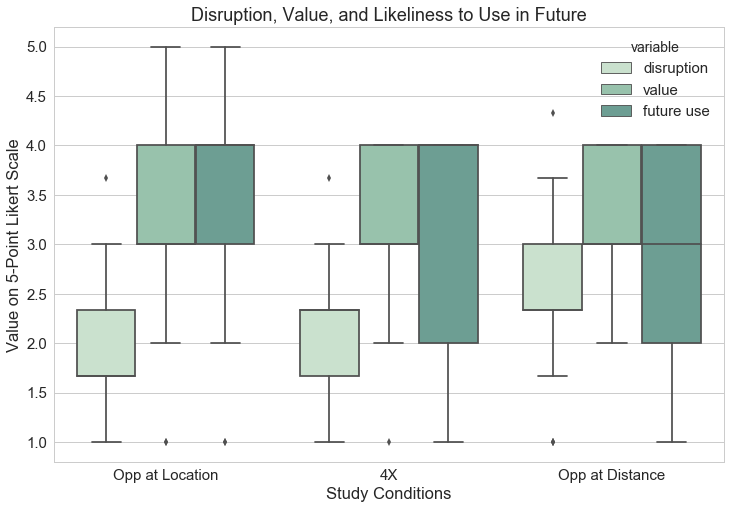

In [83]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=disruption_plot_data,
                 hue_order=['disruption', 'value', 'future use'])
ax.set_title('Disruption, Value, and Likeliness to Use in Future')
ax.set_xlabel('Study Conditions')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [84]:
post_study_opp_loc['overall_disruption'].describe()

count    28.000000
mean      2.095238
std       0.607614
min       1.000000
25%       1.666667
50%       1.666667
75%       2.333333
max       3.666667
Name: overall_disruption, dtype: float64

In [85]:
post_study_4x['overall_disruption'].describe()

count    28.000000
mean      2.095238
std       0.634126
min       1.000000
25%       1.666667
50%       2.333333
75%       2.333333
max       3.666667
Name: overall_disruption, dtype: float64

In [86]:
post_study_opp_dist['overall_disruption'].describe()

count    29.000000
mean      2.540230
std       0.856413
min       1.000000
25%       2.333333
50%       2.333333
75%       3.000000
max       4.333333
Name: overall_disruption, dtype: float64

## Test of Significance on Disruption and Value

In [87]:
F, p = stats.f_oneway(post_study_4x['overall_disruption'],
                      post_study_opp_dist['overall_disruption'],
                      post_study_opp_loc['overall_disruption'])
print('ANOVA on Disruption | F: {:1.3f}, p: {:1.3f}'.format(F, p))

ANOVA on Disruption | F: 3.750, p: 0.028


In [88]:
F, p = stats.f_oneway(post_study_4x['overall_value'],
                      post_study_opp_dist['overall_value'],
                      post_study_opp_loc['overall_value'])
print('ANOVA on Disruption | F: {:1.3f}, p: {:1.3f}'.format(F, p))

ANOVA on Disruption | F: 0.119, p: 0.888


In [89]:
F, p = stats.f_oneway(post_study_4x['future_use'],
                      post_study_opp_dist['future_use'],
                      post_study_opp_loc['future_use'])
print('ANOVA on Disruption | F: {:1.3f}, p: {:1.3f}'.format(F, p))

ANOVA on Disruption | F: 1.609, p: 0.206


## Data vs. Pickup Rate vs. Disruption

In [90]:
task_acceptance_rate_data = pd.DataFrame({
    'condition': [
        '4X',
        'Opp at Distance',
        'Opp at Location',
        '4X',
        'Opp at Distance',
        'Opp at Distance',
        
    ],
    'variable': [
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Valid Response Rate \n At Location',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (with Info) \n 300m Away',
        'Task Acceptance Rate (without Info) \n 300m Away',
    ],
    'value': [
        float(atloc_4x_count_prop_overall[atloc_4x_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_dist_count_prop_overall[atloc_opp_dist_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atloc_opp_loc_count_prop_overall[atloc_opp_loc_count_prop_overall['remappedResponses'] == 'Valid Response']['percentage']),
        float(atdist_4x_count_prop_overall[atdist_4x_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_info_count_prop_overall[atdist_opp_dist_info_count_prop_overall['emaResponse'] == 'Yes! This info is useful, I\'m going now.']['percentage']),
        float(atdist_opp_dist_noinfo_count_prop_overall[atdist_opp_dist_noinfo_count_prop_overall['emaResponse'] == 'Sure! I would be happy to go out of my way!']['percentage']),
    ]
})

disruption_value_data = pd.concat([
    pd.DataFrame({'condition': '4X', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_4x['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_disruption']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Disruption \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_disruption']}),
    pd.DataFrame({'condition': '4X', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_4x['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Distance', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_dist['overall_value']}),
    pd.DataFrame({'condition': 'Opp at Location', 'variable': 'Value \n 5-Point Likert Scale', 'value': post_study_opp_loc['overall_value']})
])

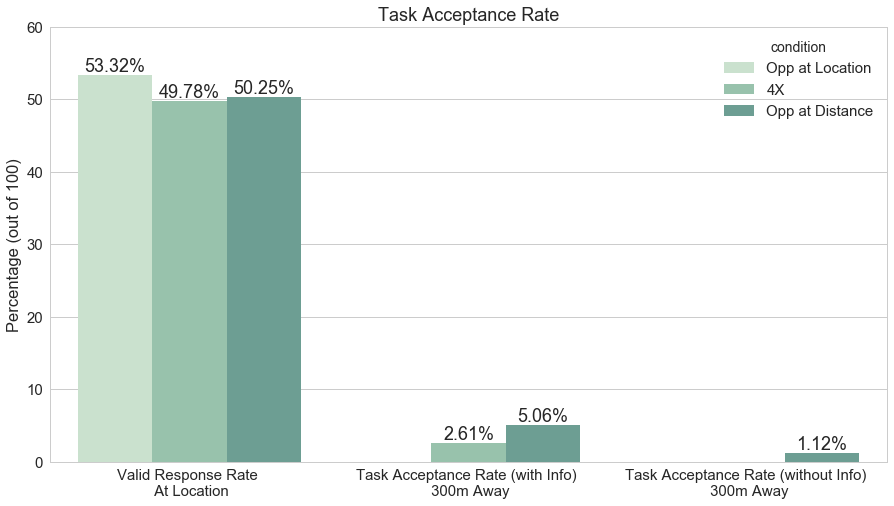

In [91]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=task_acceptance_rate_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Task Acceptance Rate')
ax.set_xlabel('')
ax.set_ylabel('Percentage (out of 100)')
ax.set_ylim(0, 60)

for p in ax.patches:
    height = p.get_height()
    if math.isnan(height):
        height = 0
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '', ha="center") 
    else:
        ax.text(p.get_x() + p.get_width() / 2, height + 0.5, '{:1.2f}%'.format(height), ha="center") 

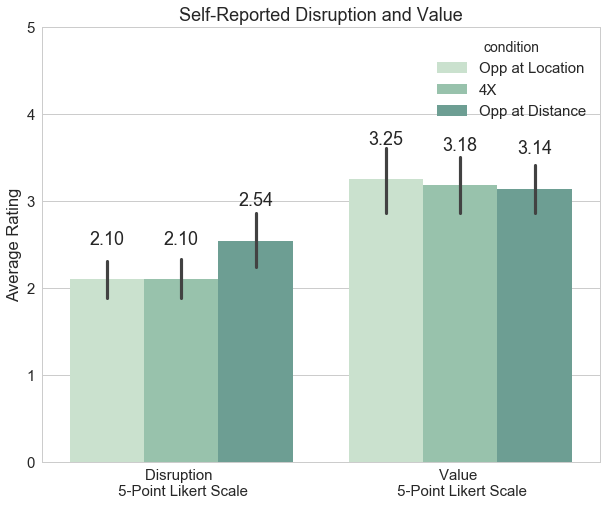

In [92]:
fig = plt.subplots(figsize=(10, 8))
ax = sns.barplot(x='variable', y='value', hue='condition', data=disruption_value_data,
                 hue_order=['Opp at Location', '4X', 'Opp at Distance'])
ax.set_title('Self-Reported Disruption and Value')
ax.set_xlabel('')
ax.set_ylabel('Average Rating')
ax.set_ylim(0, 5)

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.4, '{:1.2f}'.format(height), ha="center") 

## Info vs No Info Disruption

In [93]:
info_noinfo_plot_melted_dfs = [
    pd.DataFrame({'condition': 'Opp at Location', 'at location': post_study_opp_loc['explore_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': '4X', 'at location': post_study_4x['explore_disruption'], 'info included': post_study_4x['expand_info_disruption']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'at location': post_study_opp_dist['explore_disruption'], 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'info included': post_study_opp_dist['expand_info_disruption']}).melt(id_vars=['condition'])
]
info_disruption_plot_data = pd.concat(info_noinfo_plot_melted_dfs)
info_disruption_plot_data = info_disruption_plot_data[info_disruption_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0,0.5,'Value on 5-Point Likert Scale')

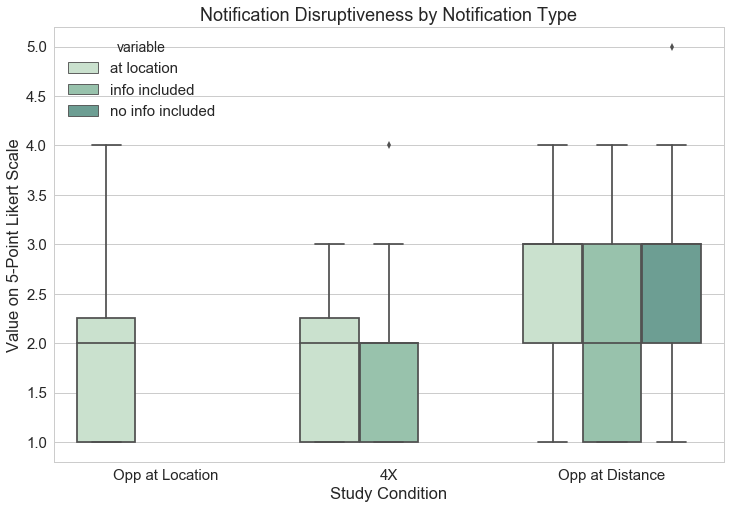

In [94]:
fig = plt.subplots(figsize=(12, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_plot_data,
                 hue_order=['at location', 'info included', 'no info included'])
ax.set_title('Notification Disruptiveness by Notification Type')
ax.set_xlabel('Study Condition')
ax.set_ylabel('Value on 5-Point Likert Scale')

In [95]:
info_noinfo_count_plot_melted_dfs = [
    pd.DataFrame({'condition': '4X', 'info included': post_study_4x['expand_info_disruption'], 'info included count': post_study_4x['expand_info_number_notif']}).melt(id_vars=['condition']),
    pd.DataFrame({'condition': 'Opp at Distance', 'no info included': post_study_opp_dist['expand_noinfo_disruption'], 'no info included count': post_study_opp_dist['expand_noinfo_number_notif'],
                  'info included': post_study_opp_dist['expand_info_disruption'], 'info included count': post_study_opp_dist['expand_info_number_notif']}).melt(id_vars=['condition'])
]
info_disruption_count_plot_data = pd.concat(info_noinfo_count_plot_melted_dfs)
info_disruption_count_plot_data = info_disruption_count_plot_data[info_disruption_count_plot_data['value'] > 0] # dont include any responses that werent filled or were NA

Text(0.5,1,'Disruptiveness and Desired Count')

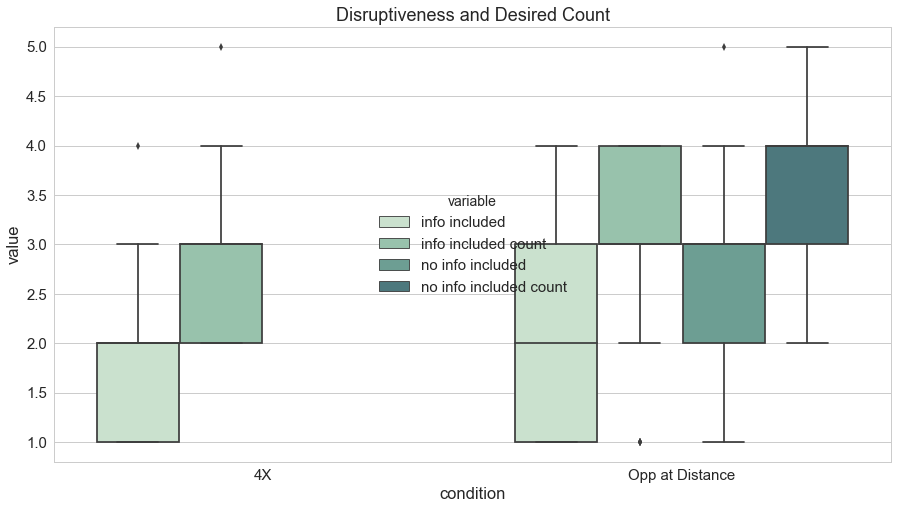

In [96]:
fig = plt.subplots(figsize=(15, 8))
ax = sns.boxplot(x='condition', y='value', hue='variable', data=info_disruption_count_plot_data,
                 hue_order=['info included', 'info included count', 'no info included', 'no info included count'])
ax.set_title('Disruptiveness and Desired Count')

## Notification Rates over Time

## Daily

### Opp Distance

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-13'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-17'),
 Text(0,0,'2018-03-18'),
 Text(0,0,'2018-03-19')]

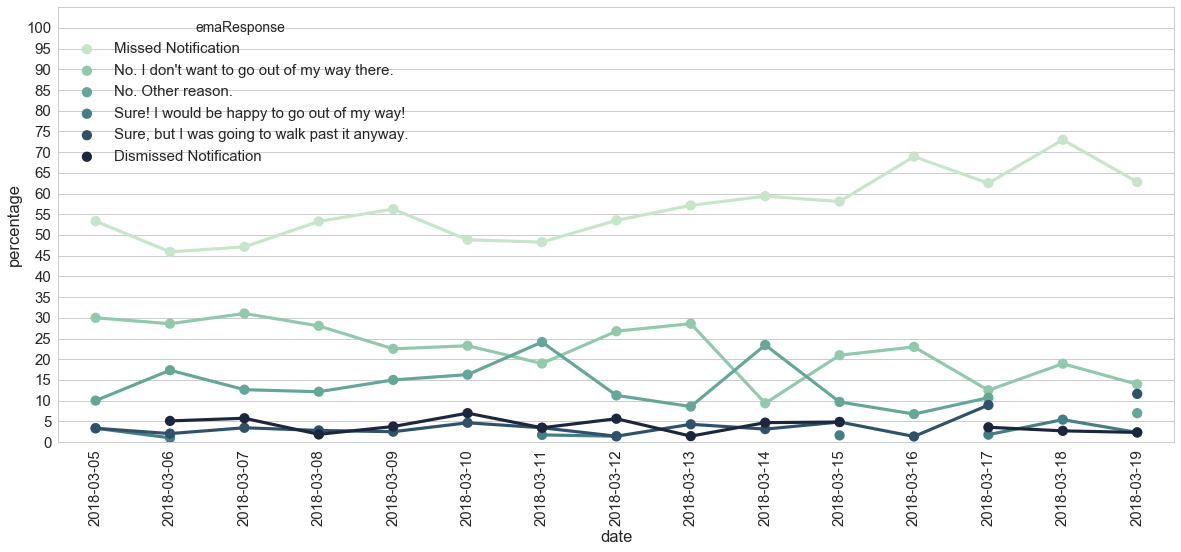

In [208]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_noinfo_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-18')]

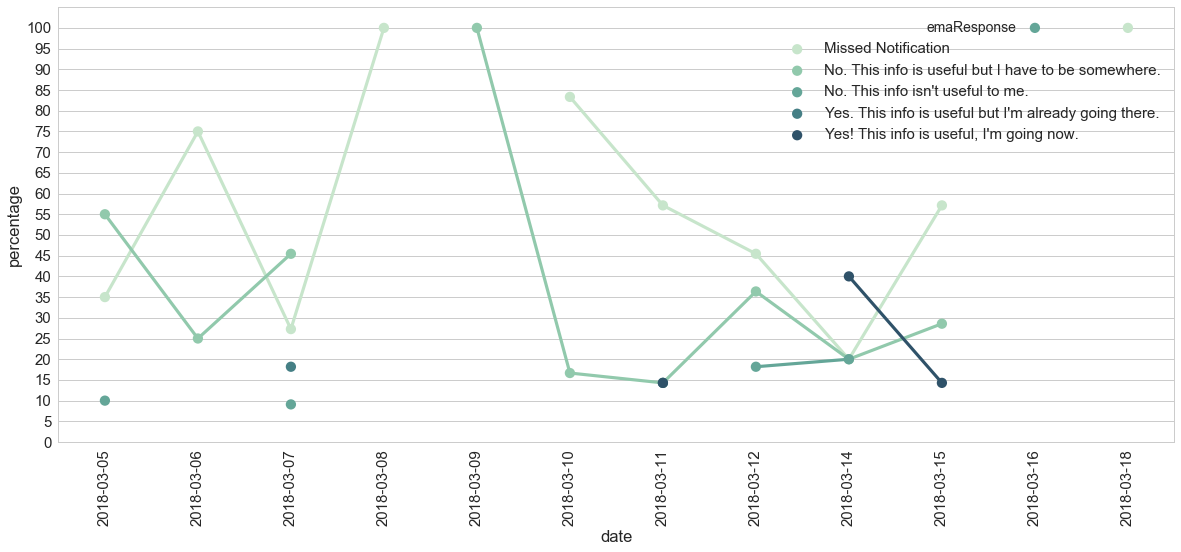

In [197]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_info_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-13'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-17'),
 Text(0,0,'2018-03-18'),
 Text(0,0,'2018-03-19')]

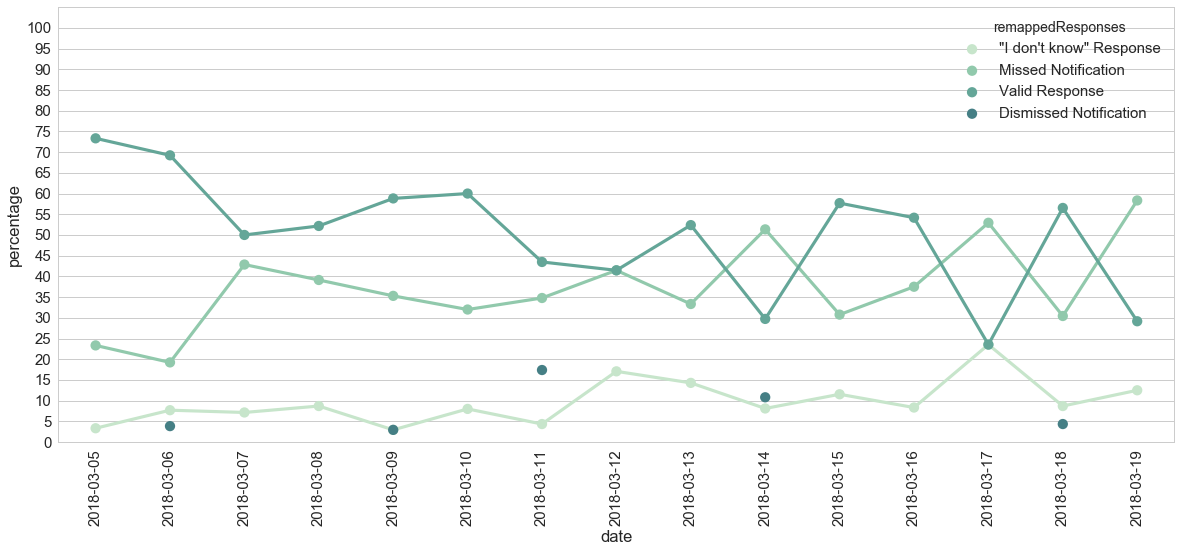

In [211]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_opp_dist_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

### 4X

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-13'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-17'),
 Text(0,0,'2018-03-19')]

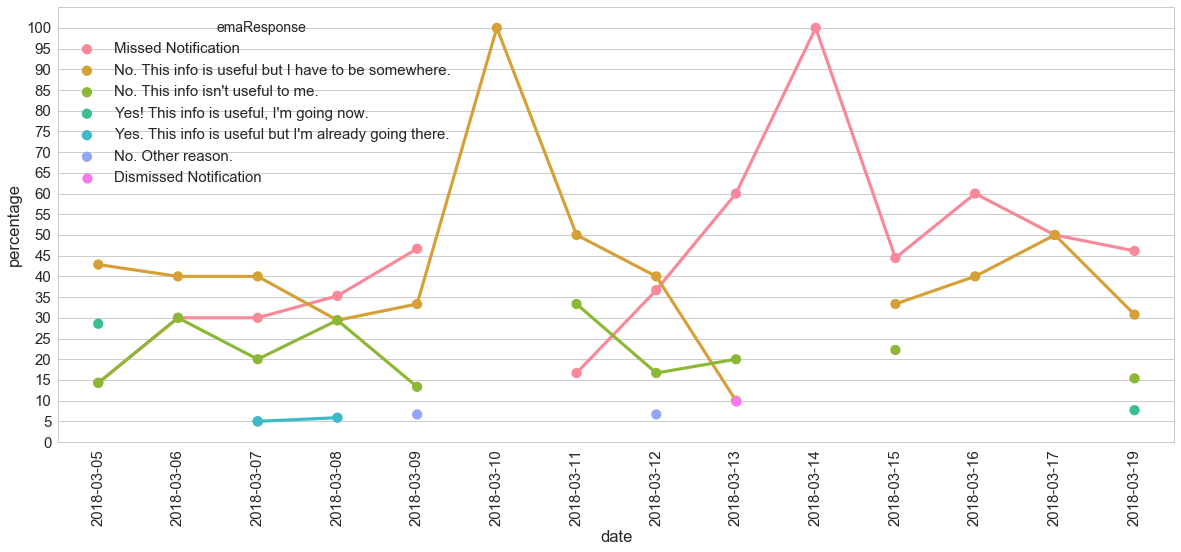

In [199]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='emaResponse',
                   data=atdist_4x_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-13'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-17'),
 Text(0,0,'2018-03-18'),
 Text(0,0,'2018-03-19')]

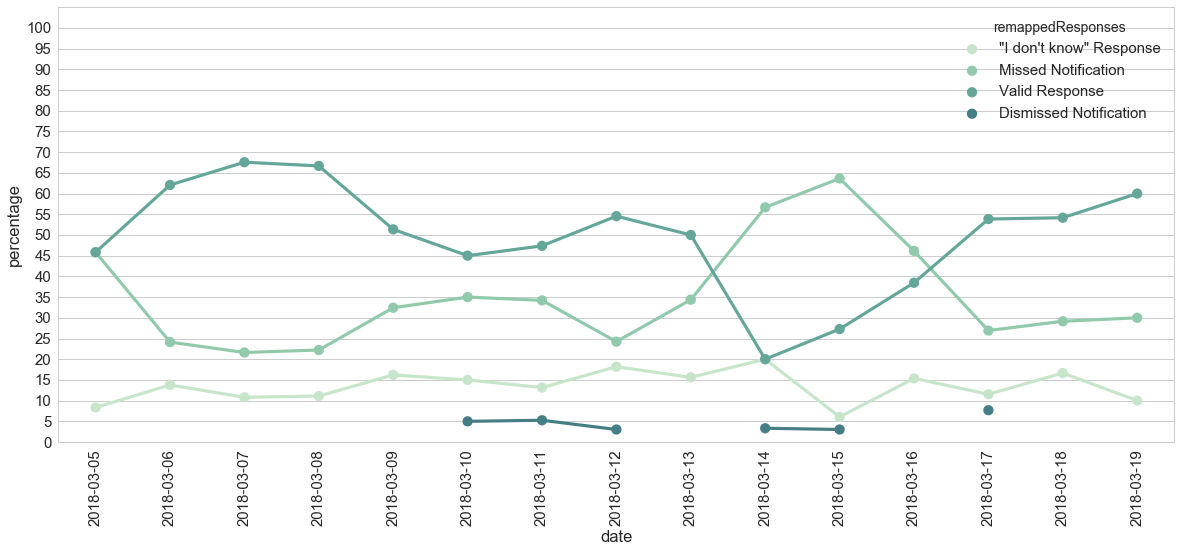

In [200]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_4x_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

### Opp Location

[Text(0,0,'2018-03-05'),
 Text(0,0,'2018-03-06'),
 Text(0,0,'2018-03-07'),
 Text(0,0,'2018-03-08'),
 Text(0,0,'2018-03-09'),
 Text(0,0,'2018-03-10'),
 Text(0,0,'2018-03-11'),
 Text(0,0,'2018-03-12'),
 Text(0,0,'2018-03-13'),
 Text(0,0,'2018-03-14'),
 Text(0,0,'2018-03-15'),
 Text(0,0,'2018-03-16'),
 Text(0,0,'2018-03-17'),
 Text(0,0,'2018-03-18'),
 Text(0,0,'2018-03-19')]

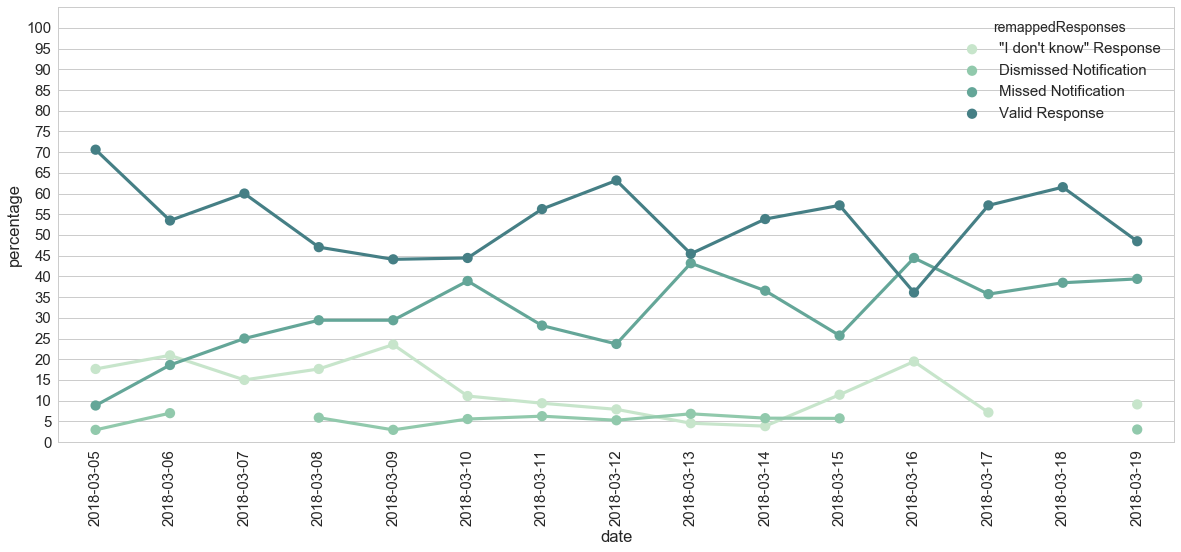

In [228]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.pointplot(x='date', y='percentage', hue='remappedResponses',
                   data=atloc_opp_loc_byday_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

## Weekly

### Opp Distance

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

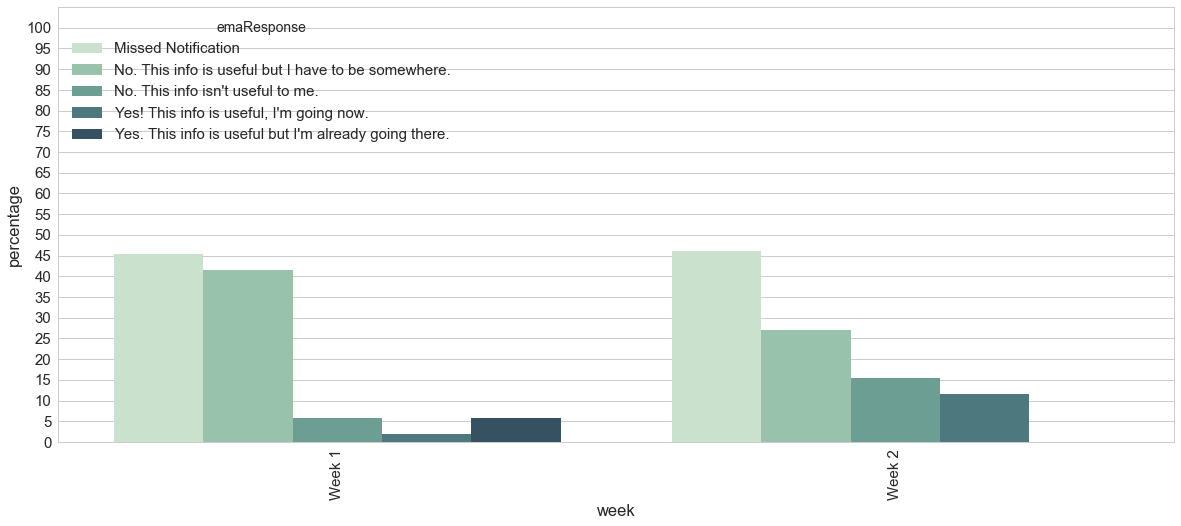

In [227]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_info_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

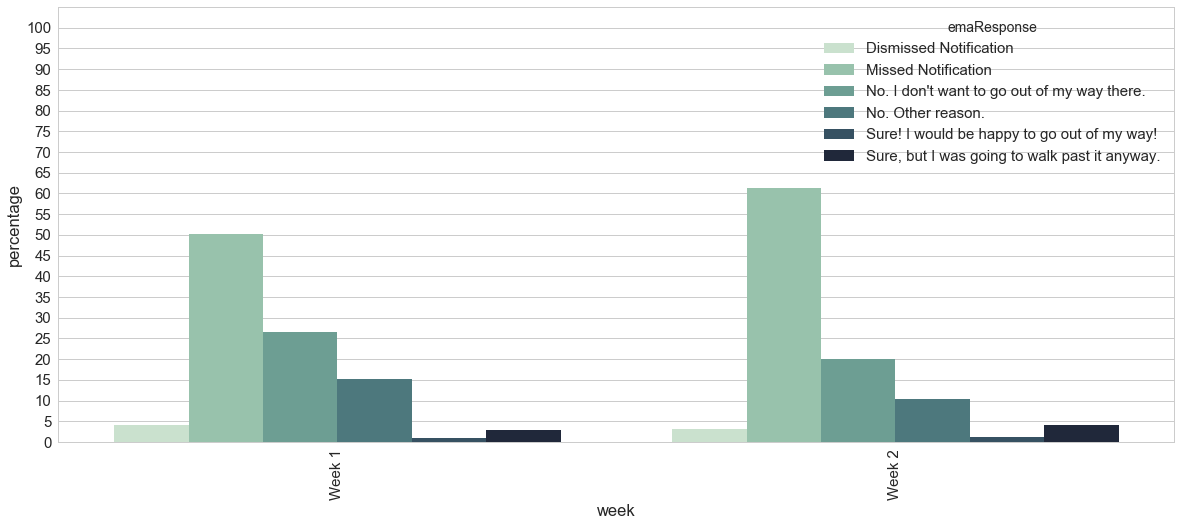

In [203]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_opp_dist_noinfo_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

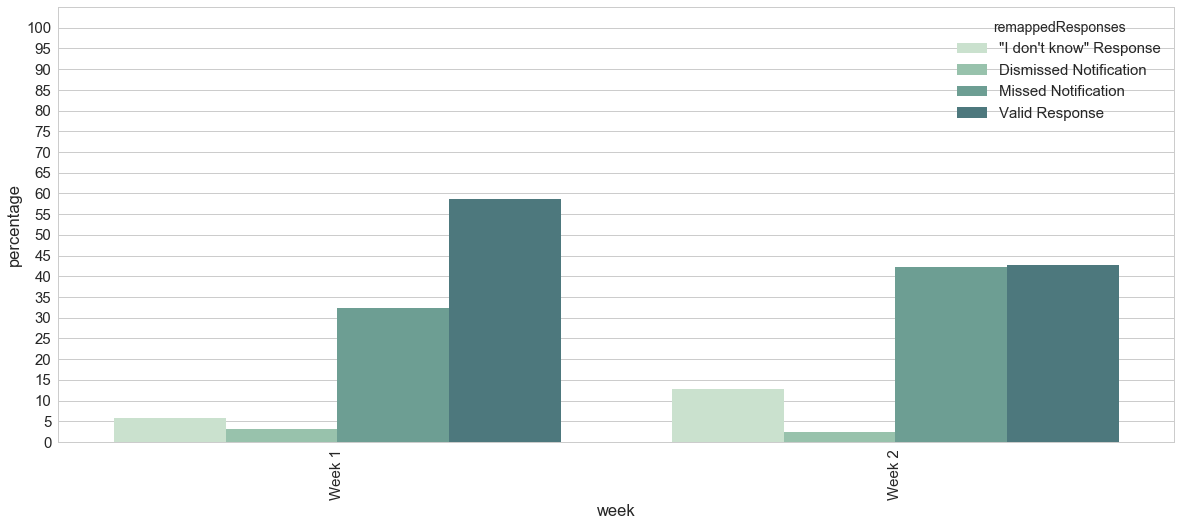

In [229]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_opp_dist_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

### 4X

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

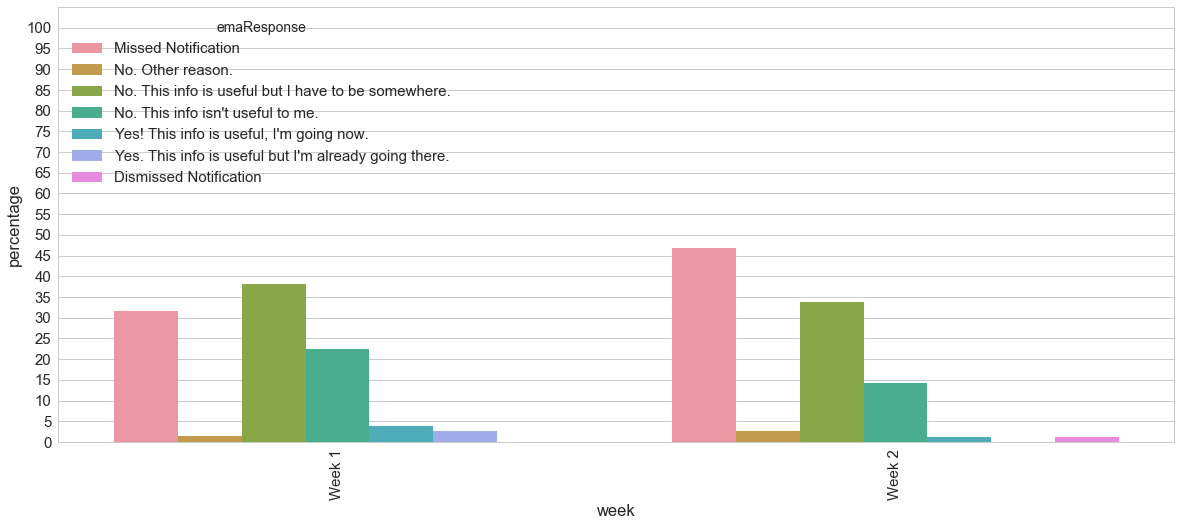

In [204]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='emaResponse',
                   data=atdist_4x_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

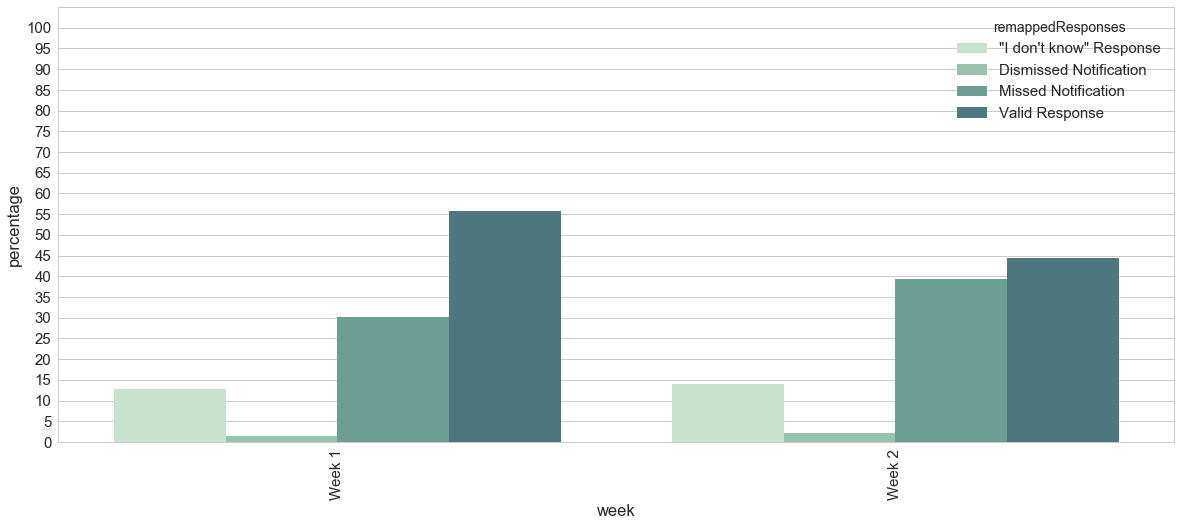

In [205]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_4x_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)

### Opp Location

[Text(0,0,'Week 1'), Text(0,0,'Week 2')]

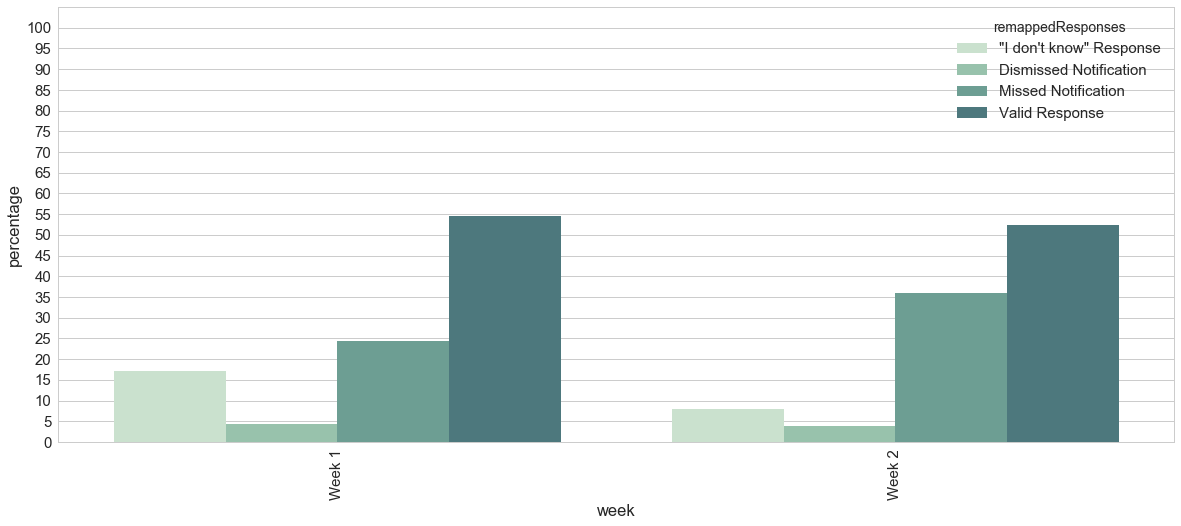

In [207]:
fig = plt.subplots(figsize=(20, 8))
ax = sns.barplot(x='week', y='percentage', hue='remappedResponses',
                   data=atloc_opp_loc_byweek_prop)

ax.set_ylim(0, 105)
ax.set_yticks(range(0, 105, 5))
loc, labels = plt.xticks()
ax.set_xticklabels(labels, rotation=90)